<a href="https://colab.research.google.com/github/MoralesTorres/ML_Notebooks/blob/master/ModelLSTMwithEncoder-DecoderAttentionUPYborrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. IMPORTING DEPENDENCIES


In [1]:
!pip install -q gradio

In [2]:
%tensorflow_version 2.x
import tensorflow as tf 
import string 
import requests 
import math
import re
import time
from google.colab import drive


In [3]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
with open("/content/drive/MyDrive/basic.txt",
          mode='r',
          encoding='utf-8') as f:
    advanced = f.read()

In [5]:
data = advanced.split('\n')
data[0]


'On weekdays except Friday (this is, from Monday to Thursday) I get up early – at half past seven. I have a white coffee and biscuits for breakfast and I go to work. I work from eight to five. I always have lunch at the office. I usually have a sandwich and a juice or a piece of fruit for lunch.'

In [6]:
data[3]

"On Friday I work from nine to one. Then I have lunch and at four I go to my course. I'm taking a course on the Internet. It's interesting. I finish at six. Then I go out for a drink with my friends."

In [7]:
len(data)

10

In [8]:
data = " ".join(data)
data[:1000]

"On weekdays except Friday (this is, from Monday to Thursday) I get up early – at half past seven. I have a white coffee and biscuits for breakfast and I go to work. I work from eight to five. I always have lunch at the office. I usually have a sandwich and a juice or a piece of fruit for lunch.  In the afternoon, I go to my English class. That's from five to six. After that, I go shopping for food and things for the house. Then I often listen to my audio CD. And I listen and repeat! Sometimes I do my homework. At about half past eight I cook dinner for my family and me. We usually have dinner at nine thirty. Then we watch TV or read. I often go to bed at about half past eleven. On Friday I work from nine to one. Then I have lunch and at four I go to my course. I'm taking a course on the Internet. It's interesting. I finish at six. Then I go out for a drink with my friends. At the weekend my day is different. On Saturday, in the morning, oh well, on Saturday morning my family and I do 

In [9]:
def clean_text(doc):
  tokens = doc.split()
  table = str.maketrans('' , '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  tokens = [word for word in tokens if word.isalpha()]
  tokens = [word.lower() for word in tokens]
  return tokens 

In [10]:
tokens = clean_text(data)
print(tokens[:50])

['on', 'weekdays', 'except', 'friday', 'this', 'is', 'from', 'monday', 'to', 'thursday', 'i', 'get', 'up', 'early', 'at', 'half', 'past', 'seven', 'i', 'have', 'a', 'white', 'coffee', 'and', 'biscuits', 'for', 'breakfast', 'and', 'i', 'go', 'to', 'work', 'i', 'work', 'from', 'eight', 'to', 'five', 'i', 'always', 'have', 'lunch', 'at', 'the', 'office', 'i', 'usually', 'have', 'a', 'sandwich']


In [11]:
len(tokens)

292

In [12]:
len(set(tokens))

124

In [13]:

from random import randint

def generate_sequence(length, n_unique):
  return [randint(0, n_unique-1) for _ in range(length)]

sequence = generate_sequence(10, 50)
print(sequence)

[16, 49, 49, 31, 49, 44, 44, 45, 16, 46]


In [14]:
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

In [15]:


def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]


In [16]:

from random import randint
from numpy import array
from numpy import argmax

# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# generate random sequence
sequence = generate_sequence(5, 50)
print(sequence)
# one hot encode
encoded = one_hot_encode(sequence, 50)
print(encoded)
# decode
decoded = one_hot_decode(encoded)
print(decoded)



[11, 30, 28, 26, 15]
[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[11, 30, 28, 26, 15]


In [17]:
# prepare data for the LSTM
def get_pair(n_in, n_out, n_unique):
	# generate random sequence
	sequence_in = generate_sequence(n_in, n_unique)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	X = one_hot_encode(sequence_in, n_unique)
	y = one_hot_encode(sequence_out, n_unique)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))
	return X,y

In [18]:
from random import randint
from numpy import array
from numpy import argmax
 
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]
 
# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)
 
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]
 
# prepare data for the LSTM
def get_pair(n_in, n_out, n_unique):
	# generate random sequence
	sequence_in = generate_sequence(n_in, n_unique)
	sequence_out = sequence_in[:n_out] + [0 for _ in range(n_in-n_out)]
	# one hot encode
	X = one_hot_encode(sequence_in, n_unique)
	y = one_hot_encode(sequence_out, n_unique)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))
	return X,y
 
# generate random sequence
X, y = get_pair(5, 2, 50)
print(X.shape, y.shape)
print('X=%s, y=%s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))

(1, 5, 50) (1, 5, 50)
X=[10, 4, 2, 29, 44], y=[10, 4, 0, 0, 0]


At this point, the Encoder-Decor generate pairs. It is seen the first two integers of the sequence followed by a padding of zero values

In [19]:
from keras import initializers

In [20]:
import tensorflow as tf
from keras import backend as K
from keras import regularizers, constraints, initializers, activations

from keras.engine import InputSpec
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [21]:
pip install attention

In [22]:
pip install keras-self-attention

In [23]:
pip install phased-lstm-keras

In [24]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.layers.wrappers import TimeDistributed

In [25]:
tfPrint = lambda d, T: tf.Print(input_=T, data=[T, tf.shape(T)], message=d)
 
class AttentionDecoder(LSTM):
 
    def __init__(self, units, output_dim,
                 activation='tanh',
                 return_probabilities=False,
                 name='AttentionDecoder',
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """
        Implements an AttentionDecoder that takes in a sequence encoded by an
        encoder and outputs the decoded states
        :param units: dimension of the hidden state and the attention matrices
        :param output_dim: the number of labels in the output space
 
        references:
            Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio.
            "Neural machine translation by jointly learning to align and translate."
            arXiv preprint arXiv:1409.0473 (2014).
        """
        self.units = units
        self.output_dim = output_dim
        self.return_probabilities = return_probabilities
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
 
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
 
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
 
        super(AttentionDecoder, self).__init__(**kwargs)
        self.name = name
        self.return_sequences = True  # must return sequences
 
    def build(self, input_shape):
        """
          See Appendix 2 of Bahdanau 2014, arXiv:1409.0473
          for model details that correspond to the matrices here.
        """
 
        self.batch_size, self.timesteps, self.input_dim = input_shape
 
        if self.stateful:
            super(AttentionDecoder, self).reset_states()
 
        self.states = [None, None]  # y, s
 
        """
            Matrices for creating the context vector
        """
 
        self.V_a = self.add_weight(shape=(self.units,),
                                   name='V_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.W_a = self.add_weight(shape=(self.units, self.units),
                                   name='W_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.U_a = self.add_weight(shape=(self.input_dim, self.units),
                                   name='U_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.b_a = self.add_weight(shape=(self.units,),
                                   name='b_a',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the r (reset) gate
        """
        self.C_r = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_r = self.add_weight(shape=(self.units, self.units),
                                   name='U_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_r = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_r = self.add_weight(shape=(self.units, ),
                                   name='b_r',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
 
        """
            Matrices for the z (update) gate
        """
        self.C_z = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_z = self.add_weight(shape=(self.units, self.units),
                                   name='U_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_z = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_z = self.add_weight(shape=(self.units, ),
                                   name='b_z',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the proposal
        """
        self.C_p = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_p = self.add_weight(shape=(self.units, self.units),
                                   name='U_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_p = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_p = self.add_weight(shape=(self.units, ),
                                   name='b_p',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for making the final prediction vector
        """
        self.C_o = self.add_weight(shape=(self.input_dim, self.output_dim),
                                   name='C_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_o = self.add_weight(shape=(self.units, self.output_dim),
                                   name='U_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_o = self.add_weight(shape=(self.output_dim, self.output_dim),
                                   name='W_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_o = self.add_weight(shape=(self.output_dim, ),
                                   name='b_o',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
 
        # For creating the initial state:
        self.W_s = self.add_weight(shape=(self.input_dim, self.units),
                                   name='W_s',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
 
        self.input_spec = [
            InputSpec(shape=(self.batch_size, self.timesteps, self.input_dim))]
        self.built = True
 
    def call(self, x):
        # store the whole sequence so we can "attend" to it at each timestep
        self.x_seq = x
 
        # apply the a dense layer over the time dimension of the sequence
        # do it here because it doesn't depend on any previous steps
        # thefore we can save computation time:
        self._uxpb = _time_distributed_dense(self.x_seq, self.U_a, b=self.b_a,
                                             input_dim=self.input_dim,
                                             timesteps=self.timesteps,
                                             output_dim=self.units)
 
        return super(AttentionDecoder, self).call(x)
 
    def get_initial_state(self, inputs):
        # apply the matrix on the first time step to get the initial s0.
        s0 = activations.tanh(K.dot(inputs[:, 0], self.W_s))
 
        # from keras.layers.recurrent to initialize a vector of (batchsize,
        # output_dim)
        y0 = K.zeros_like(inputs)  # (samples, timesteps, input_dims)
        y0 = K.sum(y0, axis=(1, 2))  # (samples, )
        y0 = K.expand_dims(y0)  # (samples, 1)
        y0 = K.tile(y0, [1, self.output_dim])
 
        return [y0, s0]
 
    def step(self, x, states):
 
        ytm, stm = states
 
        # repeat the hidden state to the length of the sequence
        _stm = K.repeat(stm, self.timesteps)
 
        # now multiplty the weight matrix with the repeated hidden state
        _Wxstm = K.dot(_stm, self.W_a)
 
        # calculate the attention probabilities
        # this relates how much other timesteps contributed to this one.
        et = K.dot(activations.tanh(_Wxstm + self._uxpb),
                   K.expand_dims(self.V_a))
        at = K.exp(et)
        at_sum = K.sum(at, axis=1)
        at_sum_repeated = K.repeat(at_sum, self.timesteps)
        at /= at_sum_repeated  # vector of size (batchsize, timesteps, 1)
 
        # calculate the context vector
        context = K.squeeze(K.batch_dot(at, self.x_seq, axes=1), axis=1)
        # ~~~> calculate new hidden state
        # first calculate the "r" gate:
 
        rt = activations.sigmoid(
            K.dot(ytm, self.W_r)
            + K.dot(stm, self.U_r)
            + K.dot(context, self.C_r)
            + self.b_r)
 
        # now calculate the "z" gate
        zt = activations.sigmoid(
            K.dot(ytm, self.W_z)
            + K.dot(stm, self.U_z)
            + K.dot(context, self.C_z)
            + self.b_z)
 
        # calculate the proposal hidden state:
        s_tp = activations.tanh(
            K.dot(ytm, self.W_p)
            + K.dot((rt * stm), self.U_p)
            + K.dot(context, self.C_p)
            + self.b_p)
 
        # new hidden state:
        st = (1-zt)*stm + zt * s_tp
 
        yt = activations.softmax(
            K.dot(ytm, self.W_o)
            + K.dot(stm, self.U_o)
            + K.dot(context, self.C_o)
            + self.b_o)
 
        if self.return_probabilities:
            return at, [yt, st]
        else:
            return yt, [yt, st]
 
    def compute_output_shape(self, input_shape):
        """
            For Keras internal compatability checking
        """
        if self.return_probabilities:
            return (None, self.timesteps, self.timesteps)
        else:
            return (None, self.timesteps, self.output_dim)
 
    def get_config(self):
        """
            For rebuilding models on load time.
        """
        config = {
            'output_dim': self.output_dim,
            'units': self.units,
            'return_probabilities': self.return_probabilities
        }
        base_config = super(AttentionDecoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [26]:
length = 10 + 1
lines = []

for i in range(length, len(tokens)):
  seq = tokens[i-length:i]
  line = ' '.join(seq)
  lines.append(line)
  if i > 5000:
    break

print(len(lines))

281


In [27]:
lines[2]

'except friday this is from monday to thursday i get up'

## Construction of our LSTM model / Training X and Y


In [28]:
tokens[30]

'to'

In [29]:
import numpy as np 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)



In [31]:
sequences = np.array(sequences)
X, y = sequences[:, :-1], sequences[:,-1]
X[0]


array([  9, 123, 121,  49, 120,  47,  16, 119,   3, 117])

In [32]:
X[1]

array([123, 121,  49, 120,  47,  16, 119,   3, 117,   1])

In [33]:
vocab_size = len(tokenizer.word_index) + 1

In [34]:
y[1]

51

In [35]:
y = to_categorical(y, num_classes=vocab_size )
X.shape[1]

10

In [36]:
seq_length = X.shape[1]
seq_length


10

In [37]:
from keras.layers import Embedding

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
pip install attention

In [40]:
pip install keras-self-attention

In [41]:
#variational LSTM dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

## LSTM MODEL

In [42]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))


In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 50)            6200      
_________________________________________________________________
lstm (LSTM)                  (None, 10, 100)           60400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 124)               12524     
Total params: 169,624
Trainable params: 169,624
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [45]:
model.fit(X, y, batch_size = 50, epochs = 250)

Epoch 1/250
6/6 [==============================] - 5s 7ms/step - loss: 4.8184 - accuracy: 0.0064 
Epoch 2/250
6/6 [==============================] - 0s 6ms/step - loss: 4.7974 - accuracy: 0.0436
Epoch 3/250
6/6 [==============================] - 0s 6ms/step - loss: 4.7147 - accuracy: 0.0660
Epoch 4/250
6/6 [==============================] - 0s 6ms/step - loss: 4.5018 - accuracy: 0.0421
Epoch 5/250
6/6 [==============================] - 0s 6ms/step - loss: 4.4043 - accuracy: 0.0819
Epoch 6/250
6/6 [==============================] - 0s 6ms/step - loss: 4.3849 - accuracy: 0.0701
Epoch 7/250
6/6 [==============================] - 0s 6ms/step - loss: 4.3260 - accuracy: 0.0832
Epoch 8/250
6/6 [==============================] - 0s 6ms/step - loss: 4.2223 - accuracy: 0.0746
Epoch 9/250
6/6 [==============================] - 0s 6ms/step - loss: 4.2645 - accuracy: 0.0830
Epoch 10/250
6/6 [==============================] - 0s 6ms/step - loss: 4.1806 - accuracy: 0.0789
Epoch 11/250
6/6 [==========

In [46]:
seed_text=lines[150]
seed_text

'have lunch and at four i go to my course im'

In [47]:

import sys, os, re, csv, codecs, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split

In [48]:

batch_size = 64
epochs = 2
model.fit(X,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4/4 [==============================] - 1s 313ms/step - loss: 0.0373 - accuracy: 0.9960 - val_loss: 0.0544 - val_accuracy: 1.0000
Epoch 2/2
4/4 [==============================] - 0s 18ms/step - loss: 0.0365 - accuracy: 0.9960 - val_loss: 0.0590 - val_accuracy: 1.0000


Text(0.5, 1.0, 'Training and validation loss')

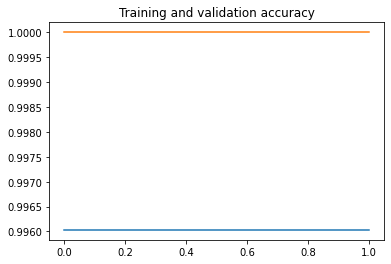

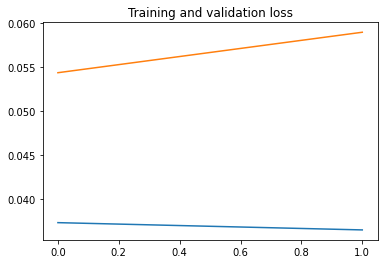

In [49]:

history = model.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# Get number of epochs\n",
epochs = range(len(acc))

# Plot training and validation accuracy per epoch\n",
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure() 

# Plot training and validation loss per epoch\n",
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [50]:
model.evaluate(X, y, verbose=1)

9/9 [==============================] - 0s 4ms/step - loss: 0.0379 - accuracy: 0.9964


[0.03785165771842003, 0.9964413046836853]

In [51]:
seed_text=lines[0]
seed_text

'on weekdays except friday this is from monday to thursday i'

In [52]:

def generate_text_seq(model, tokenizer, text_seq_length, seed_text, n_words):
  text = []

  for _ in range(n_words):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    encoded = pad_sequences([encoded], maxlen = text_seq_length, truncating='pre')

    y_predict = model.predict_classes(encoded)

    predicted_word = ''
    for word, index in tokenizer.word_index.items():
      if index == y_predict:
        predicted_word = word
        break
    seed_text = seed_text + ' ' + predicted_word
    text.append(predicted_word)
  return ' '.join(text)



In [53]:

generate_text_seq(model, tokenizer, seq_length, seed_text, 5) 

 
 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'get up early at half'

In [55]:

import gradio as gr

def prediction_text(seed_text,n_words):    
 text_seq_length = 3
 # seed_text =             "this is the" ...
 output = generate_text_seq(model, tokenizer, text_seq_length, seed_text, int(n_words)) 
 return output


iface = gr.Interface(fn=prediction_text, inputs= ["text", "text"], outputs="text")
iface.launch()




Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://24076.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://24076.gradio.app')